# Berkson Goes to College

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt2/blob/master/berkson_college.ipynb)

Suppose one day you visit Representative College, where the study body is a representative sample of the college population. You meet a randomly chosen student and you learn (because it comes up in conversation) that they got a 600 on the SAT Verbal test, which is about one standard deviation above the mean.  What do you think they got on the SAT Math test?

* A: 600 or more
* B: Between 500 and 600 (above the mean)
* C: Between 400 and 500 (below the mean)
* D: 400 or less

If you chose B, you are right! Scores on the SAT Math and Verbal tests are correlated, so if someone is above average on one, they are probably above average on the other. The correlation coefficient is about 0.7, so people who get 600 on the verbal test get about 570 on the math test, on average.

Now suppose you visit Elite University, where the average score on both tests is 700.  You meet a randomly chosen student and you learn (because they bring it up) that they got a 750 on the verbal test, which is about one standard deviation above the mean at E.U.  What do you think they got on the math test?

* A: 750 or more
* B: Between 700 and 750 (above the mean)
* C: Between 650 and 700 (below the mean)
* D: 650 or less

If you chose B again, you are wrong! Among students at E.U., the correlation between test scores is negative. If someone is above average on one, they are probably below average on the other.

This is an example of [Berkson's Paradox](https://en.wikipedia.org/wiki/Berkson's_paradox), which is a form of selection bias. In this case, the selection is the college admission process, with is partly based on exam scores. And the effect, at elite colleges and universities, is a negative correlation between test scores, even though the correlation in the general population is positive.

## Data

To see how it works in this example, let's look at some numbers.  I got data from the [National Longitudinal Survey of Youth 1997](https://www.nlsinfo.org/content/cohorts/nlsy97) (NLSY97), which "follows the lives of a sample of [8,984] American youth born between 1980-84". The public data set includes the participants' scores on several standardized tests, including the SAT and ACT.

The following cell downloads the data file.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ProbablyOverthinkingIt2/raw/master/' +
         'nlsy/stand_test_corr.csv.gz')

And I'll read the data into a Pandas `DataFrame`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('stand_test_corr.csv.gz')
df.shape

(8984, 29)

In [3]:
df.head()

,R0000100,R0536300,R0536401,R0536402,R1235800,R1482600,R5473600,R5473700,R7237300,R7237400,...,R9794001,R9829600,S1552600,S1552700,Z9033700,Z9033800,Z9033900,Z9034000,Z9034100,Z9034200
0,1,2,9,1981,1,4,-4,-4,-4,-4,...,1998,45070,-4,-4,4,3,3,2,-4,-4
1,2,1,7,1982,1,2,-4,-4,-4,-4,...,1998,58483,-4,-4,4,5,4,5,-4,-4
2,3,2,9,1983,1,2,-4,-4,-4,-4,...,-4,27978,-4,-4,2,4,2,4,-4,-4
3,4,2,2,1981,1,2,-4,-4,-4,-4,...,-4,37012,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,10,1982,1,2,-4,-4,-4,-4,...,-4,-4,-4,-4,2,3,6,3,-4,-4


The [columns are documented in the codebook](https://www.nlsinfo.org/investigator/pages/search?s=NLSY97).  The following dictionary maps the current column names to more memorable names. 

In [4]:
d = {'R9793200': 'psat_math',
     'R9793300': 'psat_verbal',
     'R9793400': 'act_comp',
     'R9793500': 'act_eng',
     'R9793600': 'act_math',
     'R9793700': 'act_read',
     'R9793800': 'sat_verbal',
     'R9793900': 'sat_math',
    }

df.rename(columns=d, inplace=True)

## ACT

Starting with the ACT, let's see what the correlations look like between the sections of the test. Of the respondents who took the ACT, most took it between 1998 and 2002, when there were [four sections](https://en.wikipedia.org/wiki/ACT_(test)#/media/File:Historical_Average_ACT_Scores.svg): English, math, reading, and science reasoning.  The dataset includes scores for the first three, and a composite score.

In [5]:
varnames = ['act_eng', 'act_math', 'act_read']

The range of valid scores is from 1 to 36. Negative values indicate missing data; there are also a few values outside the valid range that are probably errors. 

In [6]:
for varname in varnames:
    invalid = (df[varname] < 1) | (df[varname] > 36)
    df.loc[invalid, varname] = np.nan

After removing invalid data, we have ACT scores for 1266 respondents.  The average and standard deviation in this group is close to the national average (18) and standard deviation (6).

In [7]:
df['act_eng'].describe()

count    1266.000000
mean       20.276461
std         5.702592
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        35.000000
Name: act_eng, dtype: float64

In [8]:
df['act_math'].describe()

count    1266.000000
mean       20.612954
std         5.169410
min         4.000000
25%        17.000000
50%        20.000000
75%        24.000000
max        35.000000
Name: act_math, dtype: float64

In [9]:
df['act_read'].describe()

count    1267.000000
mean       21.228887
std         6.218991
min         1.000000
25%        16.000000
50%        21.000000
75%        25.000000
max        36.000000
Name: act_read, dtype: float64

Now let's see what the correlations look like among the sections of the test.

In [10]:
df[varnames].corr()

,act_eng,act_math,act_read
act_eng,1.000000,0.730127,0.805983
act_math,0.730127,1.000000,0.677565
act_read,0.805983,0.677565,1.000000


The weakest correlation, between math and reading, is 0.68.  The strongest, between English and reading, is 0.81.  The correlation between math and English is 0.73.

## SAT

We can do the same analysis with the SAT. Again, we have to remove some invalid data.

In [51]:
varnames = ['sat_verbal', 'sat_math']

for varname in varnames:
    invalid = (df[varname] < 200)
    df.loc[invalid, varname] = np.nan

About 1400 respondents took the SAT.  Their average and standard deviation are close to the national average (500) and standard deviation (100).

In [52]:
df['sat_verbal'].describe()

count    1400.000000
mean      501.678571
std       108.343678
min       200.000000
25%       430.000000
50%       500.000000
75%       570.000000
max       800.000000
Name: sat_verbal, dtype: float64

In [53]:
df['sat_math'].describe()

count    1399.000000
mean      503.213009
std       109.901382
min       200.000000
25%       430.000000
50%       500.000000
75%       580.000000
max       800.000000
Name: sat_math, dtype: float64

The correlation is about 0.73, which is consistent with the results from the ACT.

In [54]:
df[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.734739
sat_math,0.734739,1.000000


To get a sense of how strong that correlation is, here's what the scatter plot looks like.



In [55]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

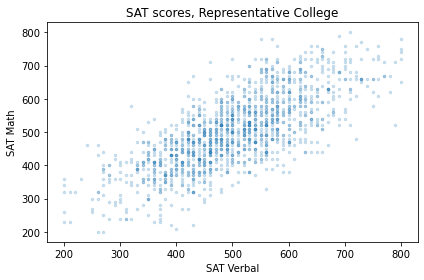

In [56]:
plt.plot(df['sat_verbal'], df['sat_math'], '.', ms=5, alpha=0.2)

decorate(xlabel='SAT Verbal',
         ylabel='SAT Math',
         title='SAT scores, Representative College')

Getting back to the first hypothetical, if we select people with verbal scores near 600, their average math score is about 570.

In [57]:
near600 = (df['sat_verbal'] >= 550) & (df['sat_verbal'] <= 650)
df.loc[near600, 'sat_math'].mean()

572.4468085106383

Since the correlation is about 0.7, someone who is one standard deviation above the mean on the verbal test is about 0.7 standard deviations above the mean on the math test, on average.

## Elite University

Now let's see what happens when we select students for Elite University. Suppose that in order to get into E.U., your total SAT score has to be 1320 or higher. Here are the total scores.

In [58]:
sat_total = df['sat_verbal'] + df['sat_math']
sat_total.describe()

count    1398.000000
mean     1004.892704
std       203.214916
min       430.000000
25%       860.000000
50%      1000.000000
75%      1140.000000
max      1580.000000
dtype: float64

And here are the respondents who would be admitted.

In [59]:
admitted = df.loc[sat_total >= 1320]
rejected = df.loc[sat_total < 1320]
admitted[varnames].describe()

,sat_verbal,sat_math
count,95.000000,95.000000
mean,699.894737,698.947368
std,53.703178,46.206606
min,550.000000,580.000000
25%,660.000000,660.000000
50%,700.000000,710.000000
75%,735.000000,730.000000
max,800.000000,800.000000


Among students at E.U, the average on both tests is about 700, and the standard deviation is about 50.  Now let's see what the correlation is.

In [60]:
admitted[['sat_verbal', 'sat_math']].corr()

,sat_verbal,sat_math
sat_verbal,1.0000,-0.3353
sat_math,-0.3353,1.0000


The correlation is about -0.33, which means that if you are one standard deviation above the E.U. mean on one test, you are about 0.33 standard deviations below the E.U. mean on the other, on average.

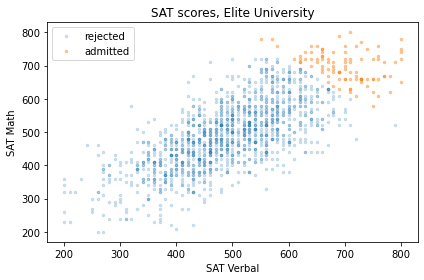

In [61]:
plt.plot(rejected['sat_verbal'], rejected['sat_math'], '.', 
         label='rejected', ms=5, alpha=0.2)
plt.plot(admitted['sat_verbal'], admitted['sat_math'], '.', 
         label='admitted', ms=5, alpha=0.4)

decorate(xlabel='SAT Verbal',
         ylabel='SAT Math',
         title='SAT scores, Elite University')

## Specialized University

Of course, most admissions decisions are based on more than the sum of two SAT scores. But we get the same effect even if the details of the admission criteria are different.  For example, suppose another school, Specialized University, admits students if either test score is 720 or better, regardless of the other score. 

In [62]:
thresh = 720
either_or = (df['sat_verbal'] >= thresh) | (df['sat_math'] >= thresh)
either_or.sum()

71

With this threshold, the mean for both tests is close to 700, the same as Elite University, but the standard deviations are a little higher.

In [63]:
admitted2 = df[either_or]
rejected2 = df[~either_or]
admitted2[varnames].describe()

,sat_verbal,sat_math
count,71.000000,71.000000
mean,697.042254,704.225352
std,74.668685,59.128479
min,500.000000,480.000000
25%,650.000000,660.000000
50%,720.000000,720.000000
75%,750.000000,740.000000
max,800.000000,800.000000


The correlation is negative, and a little stronger than at E.U., about -0.38, compared to 0.33.

In [64]:
admitted2[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,-0.382499
sat_math,-0.382499,1.000000


The following figure shows the distribution of scores for admitted students.

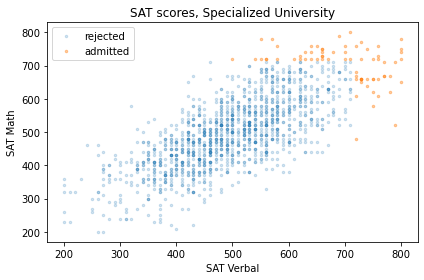

In [65]:
plt.plot(rejected2['sat_verbal'], rejected2['sat_math'], '.', 
         label='rejected', ms=5, alpha=0.2)
plt.plot(admitted2['sat_verbal'], admitted2['sat_math'], '.', 
         label='admitted', ms=5, alpha=0.4)

decorate(xlabel='SAT Verbal',
         ylabel='SAT Math',
         title='SAT scores, Specialized University')

## Sweep the Threshold

Now let's see what happens as we vary the admissions requirements. I'll go back to the previous version, where admission depends on the total of the two tests, and vary the threshold.

In [66]:
corr_series = pd.Series([], dtype=float)

for thresh in np.arange(700, 1400, 50):
    admitted = df.loc[sat_total >= thresh]
    mean = admitted[varnames].mean().sum()
    corr = admitted[['sat_verbal', 'sat_math']].corr()
    corr_series[mean] = corr.iloc[0][1]
    
corr_series

1029.210326    0.685154
1042.343626    0.661058
1061.074450    0.620211
1081.532110    0.576750
1105.520408    0.519278
1131.498258    0.452663
1162.220690    0.392761
1195.884354    0.301356
1235.906040    0.193192
1269.568966    0.087910
1303.692308   -0.019167
1342.485876   -0.102005
1380.423729   -0.245565
1413.333333   -0.323388
dtype: float64

As we increase the threshold, the average total score increase and the correlation decreases.  The following figure shows the results.

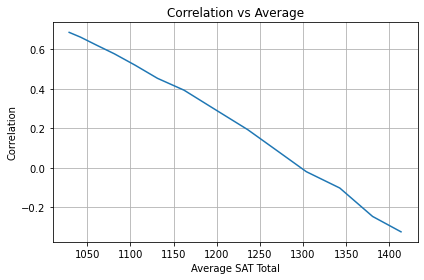

In [67]:
corr_series.plot(label='')

decorate(xlabel='Average SAT Total',
         ylabel='Correlation',
         title='Correlation vs Average')
plt.grid()

At Representative College, where the average total SAT is near 1000, test scores are strongly correlated.
At a selective college where the average is around 1300, the correlation is close to 0.  And at Elite University, where the average is over 1400, the correlation is moderately negative.


## Secondtier College

But at a college that is selective but not elite, the effect might be even stronger than that. Suppose at Secondtier College (it's pronounced "seh con' tea yay'"), a student with a total score of 1220 or more is admitted, but a student with 1320 or more is likely to go somewhere else.

In [83]:
criteria = (sat_total >= 1220) & (sat_total < 1320)
criteria.sum()

136

In [84]:
admitted3 = df.loc[criteria]
rejected3 = df.loc[~criteria]
admitted3[varnames].describe()

,sat_verbal,sat_math
count,136.000000,136.000000
mean,615.073529,643.308824
std,46.075563,45.183661
min,500.000000,520.000000
25%,580.000000,610.000000
50%,620.000000,650.000000
75%,642.500000,680.000000
max,790.000000,720.000000


In that case, the average total score would be about 1260. 

In [85]:
admitted3[varnames].mean().sum()

1258.3823529411766

Based on the parameter sweep in the previous section, we would expect a weak positive correlation, but...

In [78]:
admitted3[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,-0.802996
sat_math,-0.802996,1.000000


The correlation is actually strongly negative. The following picture shows why!

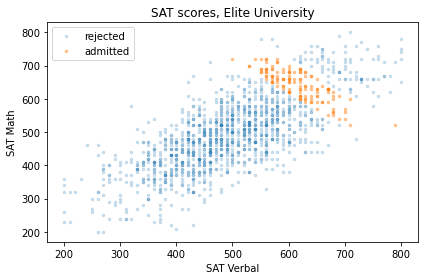

In [79]:
plt.plot(rejected3['sat_verbal'], rejected3['sat_math'], '.', 
         label='rejected', ms=5, alpha=0.2)
plt.plot(admitted3['sat_verbal'], admitted3['sat_math'], '.', 
         label='admitted', ms=5, alpha=0.4)

decorate(xlabel='SAT Verbal',
         ylabel='SAT Math',
         title='SAT scores, Secondtier College')

At Secondtier, if you meet a student who got a 690 on the math test, about one standard deviation above the mean, you should expect them to get a 580 on the verbal test, on average. That's a remarkable effect.

In [86]:
admitted3['sat_math'].mean() + admitted3['sat_math'].std()  

688.4924840808532

In [87]:
admitted3['sat_verbal'].mean() -0.8 * admitted3['sat_verbal'].std()  

578.2130789199773

## Leftovers

The rest of this notebook is a similar exploration I did with synthetic data.

It explores the effect of clipping scores at 800, and finds that it doesn't make much difference.

In [28]:
rho = 0.75
n = 20000

x = np.random.normal(0, 1, n)
y = np.random.normal(rho * x, np.sqrt(1-rho**2), n)
np.corrcoef(x, y)

array([[1.        , 0.75243113],
       [0.75243113, 1.        ]])

In [29]:
mu = 500
sigma = 100

math = x * sigma + mu
verbal = y * sigma + mu

In [30]:
sim_df = pd.DataFrame(dict(verbal=verbal, math=math))
sim_df.describe()

,verbal,math
count,20000.000000,20000.000000
mean,500.450825,500.116049
std,99.733951,100.513764
min,132.451169,101.145356
25%,432.896472,432.019288
50%,500.665919,500.828482
75%,568.372601,567.503362
max,893.227236,858.076872


In [31]:
sim_df.corr()

,verbal,math
verbal,1.000000,0.752431
math,0.752431,1.000000


In [32]:
sig_score = 0

sim_df['sat_math'] = np.clip(sim_df['math'] + 
                           np.random.normal(0, sig_score, len(sim_df)), 
                               200, 800)

sim_df['sat_math'].describe()

count    20000.000000
mean       500.119231
std        100.347080
min        200.000000
25%        432.019288
50%        500.828482
75%        567.503362
max        800.000000
Name: sat_math, dtype: float64

In [33]:
sim_df['sat_verbal'] = np.clip(sim_df['verbal'] + 
                             np.random.normal(0, sig_score, len(sim_df)), 
                                 200, 800)

sim_df['sat_verbal'].describe()

count    20000.000000
mean       500.449253
std         99.539161
min        200.000000
25%        432.896472
50%        500.665919
75%        568.372601
max        800.000000
Name: sat_verbal, dtype: float64

In [34]:
sim_df[['sat_verbal', 'sat_math']].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.752262
sat_math,0.752262,1.000000


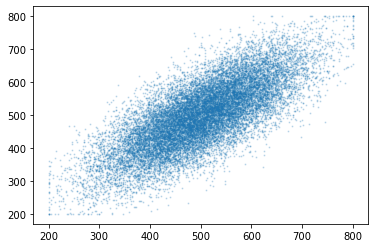

In [35]:
options = dict(ms=2, alpha=0.2)

plt.plot(sim_df['sat_verbal'], sim_df['sat_math'], '.', **options)

In [36]:
sat_total = sim_df['sat_verbal'] + sim_df['sat_math']
sat_total.describe()

count    20000.000000
mean      1000.568484
std        187.097458
min        400.000000
25%        873.120480
50%       1000.062258
75%       1130.201256
max       1600.000000
dtype: float64

In [37]:
thresh = 1440
admitted = sim_df.loc[sat_total >= thresh]
rejected = sim_df.loc[sat_total < thresh]
len(admitted)

166

In [38]:
admitted[['sat_verbal', 'sat_math']].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,-0.215239
sat_math,-0.215239,1.000000


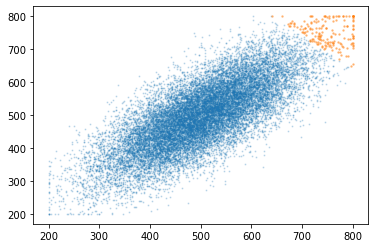

In [39]:
plt.plot(rejected['sat_verbal'], rejected['sat_math'], '.', ms=2, alpha=0.2)
plt.plot(admitted['sat_verbal'], admitted['sat_math'], '.', ms=3, alpha=0.4)



In [40]:
thresh = 754
either_or = (sim_df['sat_verbal'] > thresh) | (sim_df['sat_math'] > thresh)
either_or.sum()

170

In [41]:
admitted2 = sim_df[either_or]
rejected2 = sim_df[~either_or]

In [42]:
admitted2[['sat_verbal', 'sat_math']].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,-0.333713
sat_math,-0.333713,1.000000


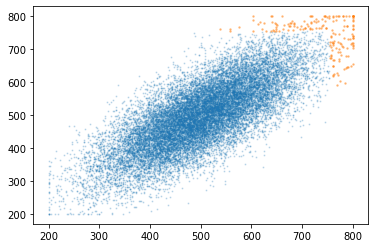

In [43]:
plt.plot(rejected2['sat_verbal'], rejected2['sat_math'], '.', ms=2, alpha=0.2)
plt.plot(admitted2['sat_verbal'], admitted2['sat_math'], '.', ms=3, alpha=0.4)